In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from helper_functions import set_seeds

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# 1. Get pretrained weights for ViT-Base

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['danger','safe']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [5]:
# Setup directory paths to train and test images
train_dir = '/raid/home/minan/home/project/project/newdataset/train'
test_dir = '/raid/home/minan/home/project/project/newdataset/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [9]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4952 | train_acc: 0.7532 | test_loss: 0.5100 | test_acc: 0.7444
Learning rate after epoch 1: 0.001
Epoch: 2 | train_loss: 0.3832 | train_acc: 0.8280 | test_loss: 0.4606 | test_acc: 0.7771
Learning rate after epoch 2: 0.001
Epoch: 3 | train_loss: 0.3403 | train_acc: 0.8555 | test_loss: 0.4411 | test_acc: 0.7667
Learning rate after epoch 3: 0.001
Epoch: 4 | train_loss: 0.3137 | train_acc: 0.8677 | test_loss: 0.4422 | test_acc: 0.7667
Learning rate after epoch 4: 0.001
Epoch: 5 | train_loss: 0.2918 | train_acc: 0.8850 | test_loss: 0.4509 | test_acc: 0.7771
Learning rate after epoch 5: 0.001
Epoch: 6 | train_loss: 0.2794 | train_acc: 0.8885 | test_loss: 0.4480 | test_acc: 0.7979
Learning rate after epoch 6: 0.001
Epoch: 7 | train_loss: 0.2639 | train_acc: 0.8982 | test_loss: 0.4585 | test_acc: 0.7875
Learning rate after epoch 7: 0.0001
Epoch: 8 | train_loss: 0.2471 | train_acc: 0.9097 | test_loss: 0.4591 | test_acc: 0.7979
Learning rate after epoch 8: 0.0001
Epoch:

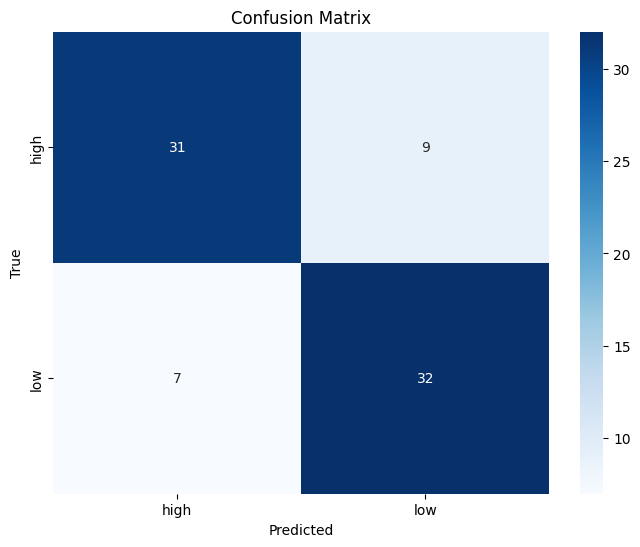

Precision: 0.7984
Recall: 0.7975
F1 Score: 0.7974
Accuracy: 0.7975
Class: high - Precision: 0.8158, Recall: 0.7750, F1: 0.7949
Class: low - Precision: 0.7805, Recall: 0.8205, F1: 0.8000


In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Function to compute predictions from the model
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions from the model
y_pred, y_true = get_predictions(pretrained_vit, test_dataloader_pretrained, device)

# Convert integer labels to string class names
y_true_classes = [class_names[i] for i in y_true]
y_pred_classes = [class_names[i] for i in y_pred]

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=class_names)

# Plot Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculating Precision, Recall, F1 Score, and Accuracy
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Display results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Optional: Per-class metrics
precision_per_class = precision_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
recall_per_class = recall_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None, zero_division=0)

for i, class_name in enumerate(class_names):
    print(f'Class: {class_name} - Precision: {precision_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}')


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

2024-11-08 00:53:42.841463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 00:53:42.859562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 00:53:42.865093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 00:53:42.878726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Define directories
train_dir = '/raid/home/minan/home/project/project/newdataset/train'
test_dir = '/raid/home/minan/home/project/project/newdataset/test'

In [14]:

# Data preprocessing (without augmentation)
train_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)
# Load the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on your model
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust based on your model
    batch_size=32,
    class_mode='binary'
)

Found 3999 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [15]:
# Load the pretrained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)  # For binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(train_generator, epochs=30, validation_data=test_generator)

2024-11-08 00:53:54.567994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37476 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-11-08 00:53:54.576291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 36788 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-11-08 00:53:54.601333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 27038 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-11-08 00:53:54.626946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 20223 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

Epoch 1/30


/raid/home/minan/home/project/project/myenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731007442.653726 1250063 service.cc:146] XLA service 0x7f831003ff30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731007442.653762 1250063 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1731007442.653850 1250063 service.cc:154]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1731007442.653853 1250063 service.cc:154]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1731007442.653855 1250063 se

  1/125 ━━━━━━━━━━━━━━━━━━━━ 19:45 10s/step - accuracy: 0.5312 - loss: 0.9988

I0000 00:00:1731007447.044576 1250063 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 334ms/step - accuracy: 0.5653 - loss: 0.7372 - val_accuracy: 0.7848 - val_loss: 0.5192
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 251ms/step - accuracy: 0.7473 - loss: 0.5199 - val_accuracy: 0.8354 - val_loss: 0.4605
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 249ms/step - accuracy: 0.7610 - loss: 0.4723 - val_accuracy: 0.7975 - val_loss: 0.4433
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 237ms/step - accuracy: 0.7834 - loss: 0.4475 - val_accuracy: 0.8228 - val_loss: 0.4366
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 252ms/step - accuracy: 0.8057 - loss: 0.4123 - val_accuracy: 0.7975 - val_loss: 0.4378
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.8131 - loss: 0.4014 - val_accuracy: 0.7722 - val_loss: 0.4444
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy: 0.8361 - loss: 0.3864 - val_accuracy: 0.7975 - val_loss: 0.4352
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.8362 - loss: 0.3675 - val

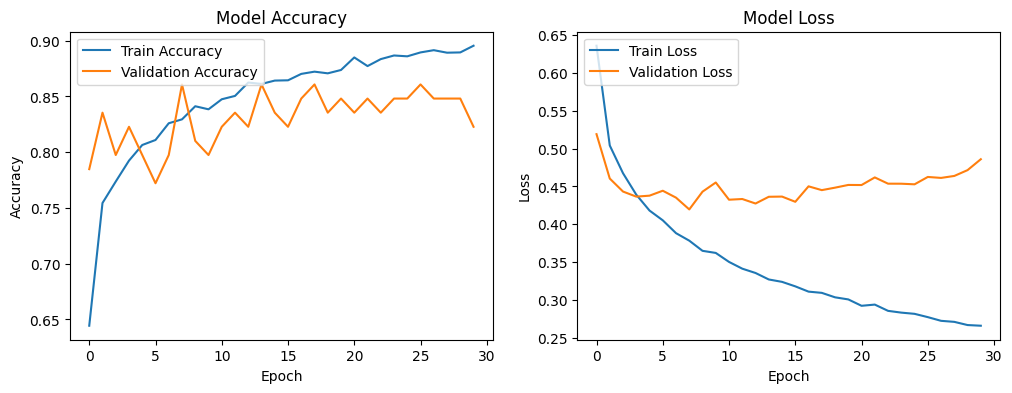

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8411 - loss: 0.4524
Test Accuracy: 82.28%
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Precision: 0.51
Recall: 0.56
F1 Score: 0.54
Confusion Matrix:
[[19 21]
 [17 22]]

Classification Report:
              precision    recall  f1-score   support

        high       0.53      0.47      0.50        40
         low       0.51      0.56      0.54        39

    accuracy                           0.52        79
   macro avg       0.52      0.52      0.52        79
weighted avg       0.52      0.52      0.52        79



In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict on the test set to calculate precision, recall, F1-score, and confusion matrix
y_true = test_generator.classes  # True labels
y_pred_cnn = (model.predict(test_generator) > 0.5).astype(int)  # Predicted labels (binary thresholding)

# Calculate precision, recall, F1-score, and print them
precision = precision_score(y_true, y_pred_cnn)
recall = recall_score(y_true, y_pred_cnn)
f1 = f1_score(y_true, y_pred_cnn)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_cnn)
print('Confusion Matrix:')
print(conf_matrix)

# Displaying the classification report for a comprehensive view of metrics
print('\nClassification Report:')
print(classification_report(y_true, y_pred_cnn, target_names=test_generator.class_indices.keys()))

Ensemble Accuracy: 0.6456
Ensemble Precision: 0.7391
Ensemble Recall: 0.4359
Ensemble F1 Score: 0.5484


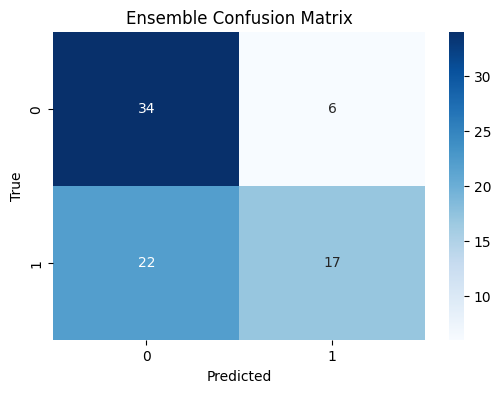

In [17]:
# Combine predictions from both models
# Assumption: y_pred_vit and y_pred_cnn are binary (0 for 'low water level' and 1 for 'high water level')
y_pred_vit=y_pred
final_predictions = []

for vit_pred, cnn_pred in zip(y_pred_vit, y_pred_cnn):
    # Apply majority voting
    vote = np.round((vit_pred + cnn_pred) / 2)
    final_predictions.append(vote)

final_predictions = np.array(final_predictions)
# Evaluate majority-voting performance
accuracy = accuracy_score(y_true, final_predictions)
precision = precision_score(y_true, final_predictions)
recall = recall_score(y_true, final_predictions)
f1 = f1_score(y_true, final_predictions)

print(f'Ensemble Accuracy: {accuracy:.4f}')
print(f'Ensemble Precision: {precision:.4f}')
print(f'Ensemble Recall: {recall:.4f}')
print(f'Ensemble F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, final_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.show()



Ensemble Accuracy: 0.7975
Ensemble Precision: 0.7805
Ensemble Recall: 0.8205
Ensemble F1 Score: 0.8000


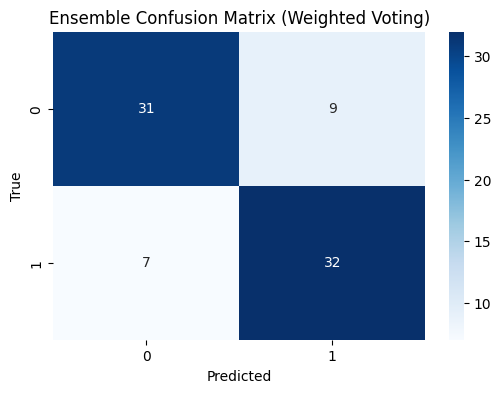

In [19]:


# Assumed weights (you can adjust based on individual model performance)
w_vit = 0.9  # Weight for ViT predictions
w_cnn = 0.6  # Weight for CNN predictions
y_pred_vit=y_pred
final_predictions = []

for vit_pred, cnn_pred in zip(y_pred_vit, y_pred_cnn):
    # Apply weighted voting
    weighted_vote = np.round((w_vit * vit_pred + w_cnn * cnn_pred) / (w_vit + w_cnn))
    final_predictions.append(weighted_vote)

final_predictions = np.array(final_predictions)

# Evaluate weighted-voting performance
accuracy = accuracy_score(y_true, final_predictions)
precision = precision_score(y_true, final_predictions)
recall = recall_score(y_true, final_predictions)
f1 = f1_score(y_true, final_predictions)

print(f'Ensemble Accuracy: {accuracy:.4f}')
print(f'Ensemble Precision: {precision:.4f}')
print(f'Ensemble Recall: {recall:.4f}')
print(f'Ensemble F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, final_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix (Weighted Voting)')
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [21]:
# Define directories
train_dir = '/raid/home/minan/home/project/project/newdataset/train'
test_dir = '/raid/home/minan/home/project/project/newdataset/test'

In [22]:

# Data preprocessing (without augmentation)
train_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)
# Load the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on your model
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust based on your model
    batch_size=32,
    class_mode='binary'
)

Found 3999 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [23]:
# Load the pretrained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)  # For binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(train_generator, epochs=30, validation_data=test_generator)

Epoch 1/30


/raid/home/minan/home/project/project/myenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 331ms/step - accuracy: 0.5309 - loss: 0.7249 - val_accuracy: 0.6203 - val_loss: 0.6711
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.6731 - loss: 0.6523 - val_accuracy: 0.6582 - val_loss: 0.6400
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step - accuracy: 0.6702 - loss: 0.6338 - val_accuracy: 0.7089 - val_loss: 0.6201
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 273ms/step - accuracy: 0.6819 - loss: 0.6184 - val_accuracy: 0.7468 - val_loss: 0.6068
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.6955 - loss: 0.5985 - val_accuracy: 0.7089 - val_loss: 0.5958
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 277ms/step - accuracy: 0.7151 - loss: 0.5868 - val_accuracy: 0.7595 - val_loss: 0.5922
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.7092 - loss: 0.5846 - val_accuracy: 0.7468 - val_loss: 0.5783
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 272ms/step - accuracy: 0.7086 - loss: 0.5858 - val

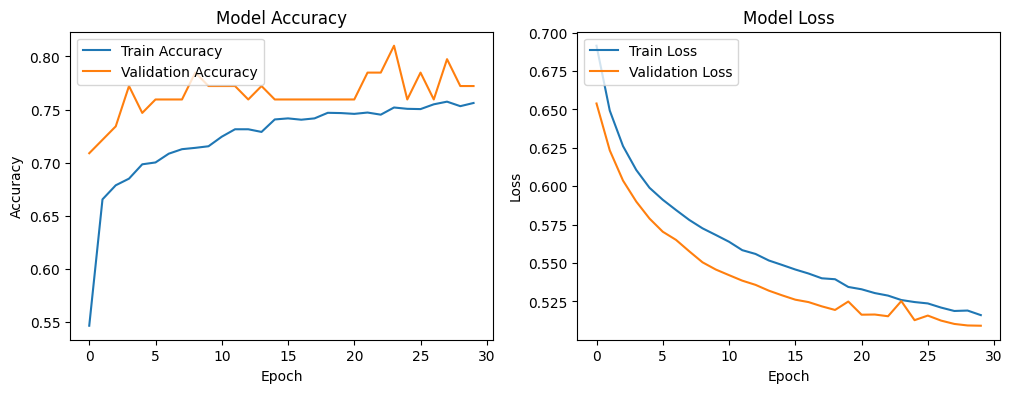

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7884 - loss: 0.4862 
Test Accuracy: 77.22%
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step
Precision: 0.46
Recall: 0.44
F1 Score: 0.45
Confusion Matrix:
[[20 20]
 [22 17]]

Classification Report:
              precision    recall  f1-score   support

        high       0.82      0.78      0.79        40
         low       0.78      0.82      0.80        39

    accuracy                           0.80        79
   macro avg       0.80      0.80      0.80        79
weighted avg       0.80      0.80      0.80        79



In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict on the test set to calculate precision, recall, F1-score, and confusion matrix
y_true = test_generator.classes  # True labels
y_pred_vgg = (model.predict(test_generator) > 0.5).astype(int)  # Predicted labels (binary thresholding)

# Calculate precision, recall, F1-score, and print them
precision = precision_score(y_true, y_pred_vgg)
recall = recall_score(y_true, y_pred_vgg)
f1 = f1_score(y_true, y_pred_vgg)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_vgg)
print('Confusion Matrix:')
print(conf_matrix)

# Displaying the classification report for a comprehensive view of metrics
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

Ensemble Accuracy: 0.6329
Ensemble Precision: 0.7778
Ensemble Recall: 0.3590
Ensemble F1 Score: 0.4912


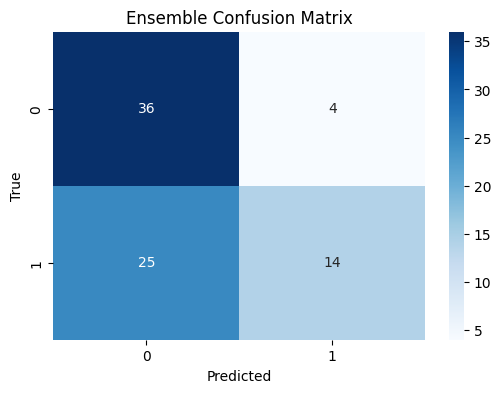

In [24]:
# Ensure all predictions (y_pred_vit, y_pred_cnn, y_pred_vgg) are binary (0 or 1)
final_predictions = []

for vit_pred,  vgg_pred in zip(y_pred_vit,  y_pred_vgg):
    # Apply majority voting among three models
    vote = np.round((vit_pred + cnn_pred + vgg_pred) / 3)
    final_predictions.append(vote)

final_predictions = np.array(final_predictions)

# Evaluate the majority-voting ensemble performance
accuracy = accuracy_score(y_true, final_predictions)
precision = precision_score(y_true, final_predictions)
recall = recall_score(y_true, final_predictions)
f1 = f1_score(y_true, final_predictions)

print(f'Ensemble Accuracy: {accuracy:.4f}')
print(f'Ensemble Precision: {precision:.4f}')
print(f'Ensemble Recall: {recall:.4f}')
print(f'Ensemble F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, final_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.show()